<div style="background-color: #00FF00; padding: 20px;">
    <p style='text-align:center;
              font-family: sans-serif;
              font-weight:bold;
              color:black;
              font-size:50px;
              margin: 5px;'> 
        <font color='blue'; size='7'>Anomaly Detection</font>
    </p>
    <p style="text-align:center;
              font-family: sans-serif;
              font-weight:bold;
              color:tomato;
              font-size:40px;
              margin: 10px;">
        GAN Model
    </p>
</div>

<h1 style="text-align: center; color: WHITE; font-size:30px; background-color: #00FF00; padding: 10px; border-radius: 5px;">
    Project Workflow
</h1>

### 1. Data Preparation
   - Load data
   - Inspect Class Imbalance
   - Split the data into train and test sets

### 2. Data Preprocessing
   - Balance the training data (Use SMOTE)
   - Data Scaling
   - Feature Reduction: PCA

### 3. Model Building
   - Define GAN c    omponents:
	- Build the `gan`, `generator`, and `discriminator` models.
   - Train the GAN model

### 4. Model Evaluation
   - Evaluate the model on the imbalanced test data
 : - Model metris: Calculate ROC AUC, classification report, and other relevant metrics.
  
### 4. Model Deolyment
   - save the trained models
   - Deploy the saved models
       eeded for future use)lrovide a clear and logical flow for your project, ensuring that all critical steps are covered.

<h1 style="text-align: center; color: WHITE; font-size:30px; background-color: #00FF00; padding: 10px; border-radius: 5px;">
    Part-1: Model Building
</h1>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')


In [23]:
# Load the data
df = pd.read_csv('creditcard.csv')
df.head()

# Inspect Class Ratio 
class_ratio = df['Class'].value_counts(normalize=True)
print("class_ratio in the dataframe:", class_ratio)

# Balance the class ratio
X = df.drop('Class', axis=1)
y = df['Class']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Count the class distribution in the training set prior to Balancing
train_class_ratio = y_train.value_counts(normalize=True)
print("\nTraining set class distribution prior to Balancing:")
print(train_class_ratio)

# Count the class distribution in the test set
test_class_ratio = y_test.value_counts(normalize=True)
print("\nTest set class distribution:")
print(test_class_ratio)

# Apply SMOTE only to the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Count the class distribution in the training set After Balancing
train_class_ratio = y_train_res.value_counts(normalize=True)
print("\nTraining set class distribution After Class Balancing:")
print(train_class_ratio)

# Feature Reduction and PCA
# Data Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

class_ratio in the dataframe: Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Training set class distribution prior to Balancing:
Class
0    0.998275
1    0.001725
Name: proportion, dtype: float64

Test set class distribution:
Class
0    0.998268
1    0.001732
Name: proportion, dtype: float64

Training set class distribution After Class Balancing:
Class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [3]:
# Define user Functions

# Model Building
def build_gan():
    generator = Sequential([
        Dense(128, input_dim=10),
        LeakyReLU(alpha=0.2),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(512),
        LeakyReLU(alpha=0.2),
        Dense(10)
    ])

    discriminator = Sequential([
        Dense(512, input_dim=10),
        LeakyReLU(alpha=0.2),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])

    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    gan = Sequential([generator, discriminator])
    discriminator.trainable = False
    gan.compile(optimizer='adam', loss='binary_crossentropy')
    
    return gan, generator, discriminator


# Train the GAN model using the training data.
def train_gan(gan, generator, discriminator, X_train_pca, y_train, epochs=100, batch_size=64):
    for epoch in range(epochs):
        for _ in range(batch_size):
            noise = tf.random.normal([batch_size, 10])
            generated_data = generator.predict(noise)
            
            idx = np.random.randint(0, X_train_pca.shape[0], batch_size)
            real_data = X_train_pca[idx]
            
            real_labels = np.ones((batch_size, 1))  # Corrected for binary classification
            fake_labels = tf.zeros((batch_size, 1))
            
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(real_data, real_labels)
            d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)
        
        noise = tf.random.normal([batch_size, 10])
        valid_y = tf.ones((batch_size, 1))
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, valid_y)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Discriminator Real Loss: {d_loss_real[0]:.4f}, Discriminator Fake Loss: {d_loss_fake[0]:.4f}")
        print(f"  Generator Loss: {g_loss}")
        print("")


In [4]:
%%time

# Build a gan model
gan, generator, discriminator = build_gan()

# Train the GAN model using the training data.
train_gan(gan, generator, discriminator, X_train_pca, y_train_res, epochs=50, batch_size=64)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

In [5]:
# Step 5: Test the Model and Compute Metrics
y_pred = discriminator.predict(X_test_pca)
y_pred_class = (y_pred > 0.5).astype(int)

print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred_class))

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step
ROC AUC: 0.5617789135638951
              precision    recall  f1-score   support

           0       1.00      0.10      0.19     85295
           1       0.00      0.78      0.00       148

    accuracy                           0.10     85443
   macro avg       0.50      0.44      0.10     85443
weighted avg       0.99      0.10      0.19     85443



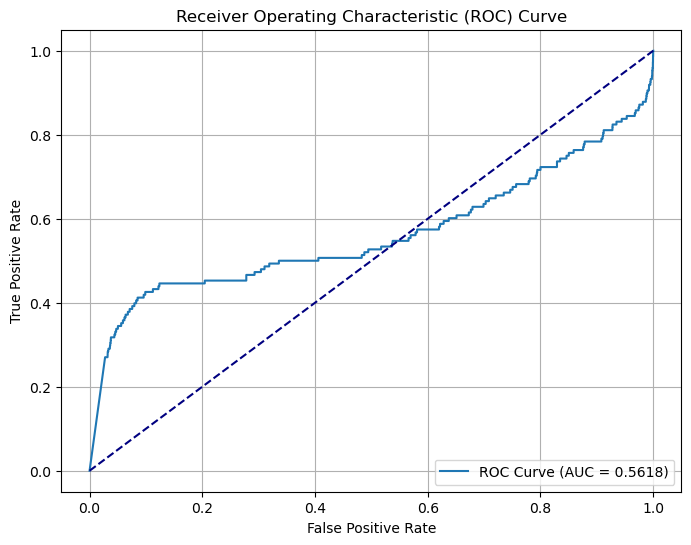

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Generate ROC curve values: false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(roc_auc_score(y_test, y_pred)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for a random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [7]:
# #Save the trained models 

generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')

<h1 style="text-align: center; color: WHITE; font-size:30px; background-color: #00FF00; padding: 10px; border-radius: 5px;">
    Part-2: Model Deployment
</h1>

In [25]:
# # Deploy the Saved Models

import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Load the saved models
generator = load_model('generator_model.h5')
discriminator = load_model('discriminator_model.h5')

# Step 2: Get sample transaction data to be tested
# Read the 10th row from X_test (assuming X_test is a DataFrame)
sample_transaction = X_test.iloc[9]  # Index 9 corresponds to the 10th row
# Convert series to array
sample_transaction_array = sample_transaction.values
# Reshape the array to (-1, 1)
sample_transaction_reshaped = sample_transaction_array.reshape(-1, 1)

# Step 3: Preprocess the Sample Test Data
# Scale the data
scaler = StandardScaler()
sample_transaction_scaled = scaler.fit_transform(sample_transaction_reshaped)
print( type(sample_transaction_scaled) )


# Apply PCA
# pca = PCA(n_components=10)
sample_transaction_pca = pca.fit_transform(sample_transaction_scaled)
sample_transaction_pca

# Step 4: Make Predictions
prediction = discriminator.predict(sample_transaction_pca)

# Step 5: Interpret the Prediction
if prediction > 0.5:
    print("The transaction is likely REAL.")
else:
    print("The transaction is likely FAKE (Anomaly).")
